## Real vs Fake Faces - Model Testing

Se utilizará el conjunto de datos de "10k Real vs. Fake Faces", inicialmente destinado para el proyecto "Real vs Fake Face Detection project" del Equipo de Ciencia de Datos de Michigan. Con la proliferación de deepfakes y manipulaciones de imágenes, surge la pregunta: ¿Es posible entrenar un algoritmo de aprendizaje automático para distinguir entre rostros reales y falsos?

El objetivo de este apartado es testear diferentes modelos eligiendo como baseline un modelo convolucional simple:

In [1]:
# Importamos librerías en general
from IPython.display import display
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image
import random
import seaborn as sns

# Importamos desde sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

# Importamos desde PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset

In [2]:
# Importamos los sets de datos
train = pd.read_csv('../data/raw/train.csv')
valid = pd.read_csv('../data/raw/valid.csv')

In [3]:
# Agregamos la etapa de transformación
def transform(image):
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    return transform(image)

In [4]:
# Generamos un dataloader
class FacesDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # columna 5 contiene el path relativo
        img_name = os.path.join(self.root_dir, self.dataframe.iloc[idx, 5])
        image = Image.open(img_name)
        # columna 3 contiene el label numérico (real=1 | fake=0)
        label = self.dataframe.iloc[idx, 3]

        if self.transform:
            image = self.transform(image)

        return image, label

In [5]:
# Tomamos los datasets 
train_dataset = FacesDataset(dataframe=train, root_dir='../data/raw/', transform=transform)
valid_dataset = FacesDataset(dataframe=valid, root_dir='../data/raw/', transform=transform)

# Generamos los dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

In [6]:
# Generamos el device de uso
# mps es para Macs con chip M1
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# cuda es para device con Nvidia
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
# Definimos una función que entrene el modelo elegido
def train_model(model, 
                optimizer, 
                criterion = nn.CrossEntropyLoss(), 
                train_loader = train_loader, 
                num_epochs=10, 
                device=device):
    seed = 42
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
    model = model.to(device)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}')

In [8]:
# Generamos una función que permita evaluar el modelo
def evaluate_model(model, 
                   valid_loader = valid_loader, 
                   device=device):
    seed = 42
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print(f'Accuracy: {accuracy_score(all_labels, all_preds)}')

    # report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds))

    # confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='g')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

In [13]:
# Definimos una función que plotee los resultados
def plot_predictions(model, 
                     valid_loader = valid_loader, 
                     label_map = {0: 'fake', 1: 'real'}, 
                     device=device):
    plt.figure(figsize=(10, 10))
    
    images, labels = next(iter(valid_loader))
    
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].cpu().permute(1, 2, 0))
        color = 'green' if predicted[i].item() == labels[i].item() else 'red'
        plt.title(f'Actual: {label_map[labels[i].item()]}, Predicted: {label_map[predicted[i].item()]}', color=color)
        plt.axis('off')

    plt.show()

### CNN

In [9]:
# Probamos con un modelo simple convolucional
class ConvBaselineModel(torch.nn.Module):
    def __init__(self, output_units):
        super(ConvBaselineModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding='same')
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same')
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding='same')
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(in_features=131072, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=output_units)

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = self.pool3(torch.relu(self.conv3(x)))
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [10]:
first_model = ConvBaselineModel(2)
optimizer = torch.optim.Adam(first_model.parameters(), lr=0.0001)
train_model(first_model, optimizer, num_epochs = 10)

Epoch 1/10, Loss: 0.6715728689546454
Epoch 2/10, Loss: 0.591085169957653
Epoch 3/10, Loss: 0.525809726622551
Epoch 4/10, Loss: 0.45939192556899433
Epoch 5/10, Loss: 0.39850001071141733
Epoch 6/10, Loss: 0.337385122430379
Epoch 7/10, Loss: 0.26914673485712376
Epoch 8/10, Loss: 0.21149411317828584
Epoch 9/10, Loss: 0.1653822510243823
Epoch 10/10, Loss: 0.10733956623329147


Accuracy: 0.8153333333333334
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.88      0.83      1500
           1       0.86      0.75      0.80      1500

    accuracy                           0.82      3000
   macro avg       0.82      0.82      0.81      3000
weighted avg       0.82      0.82      0.81      3000



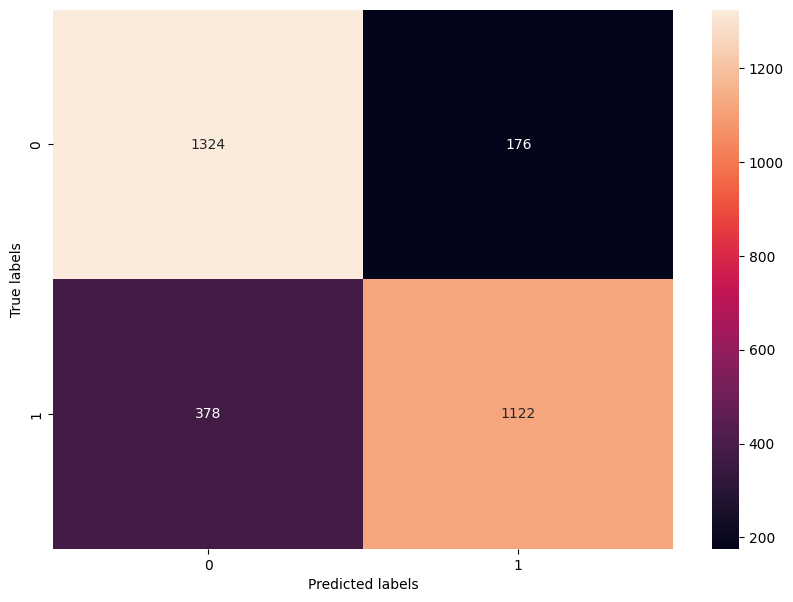

In [11]:
evaluate_model(first_model)

In [20]:
# plot_predictions(first_model)